# <font ><center> **Analyse des sentiments** 

#### <font><center> Réalisé par: BOUYAKHSAINE Khadija && EL MARRADI Noura && BENDAOUCH Fatima

Airbnb a réussi à bouleverser le secteur de l'hôtellerie traditionnelle, car de plus en plus de voyageurs décident d'utiliser Airbnb comme principal fournisseur d'hébergement. 
 Il collecte de nombreuses données sur leurs hôtes et leurs propriétés, y compris des avis détaillés sur les touristes


**Objectif :**  Analyser les sentiments des avis des touristes 

## Chargement des données:

In [652]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

df_reviews = pd.read_csv('reviews.csv')
df_listings = pd.read_csv('listings.csv')

In [653]:
print("df_reviews contient  {} lignes et {} coloune.".format(*df_reviews.shape))

df_reviews contient  109584 lignes et 6 coloune.


In [654]:
print("df_listings contient  {} lignes et {} coloune.".format(*df_listings.shape))

df_listings contient  4914 lignes et 74 coloune.


In [655]:
#fill nans with none in comments
df_reviews.comments.fillna('none',inplace=True)

In [656]:
#join all reviews together by listing_id (this will allow me run tf-idf on all my reviews together and look for topics/features)
df_reviews=df_reviews.groupby(['listing_id'])['comments'].apply(','.join).reset_index()

- Dans un premier temps on va combiner les données de reviews.csv et listings.csv par listing_id 

In [657]:
df_combined=pd.merge(df_listings[[ 'host_id', 'id','review_scores_rating']], df_reviews, left_on='id', right_on='listing_id', how='left')

- puis en utlisant la fonction groupby(), On va regrouper les commentaires de chaque host et le review_scores_rating associée a ce dernier.

In [658]:
host_reviews = df_combined.groupby(['host_id','comments'], as_index=False)['review_scores_rating'].mean()
host_reviews.head(4)

,host_id,comments,review_scores_rating
0,14678,"Theresa's flat was very comfortable, clean, we...",5.00
1,37354,Werner has a great flat in a really convenient...,4.78
2,76217,Dani is a warm and welcoming host. Good public...,4.86
3,86473,My stay at Barbara's was so far my best experi...,4.87


In [659]:
print("Notre dataset  contient  {} lignes et {} coloune.".format(*host_reviews.shape))

Notre dataset  contient  3787 lignes et 3 coloune.


In [660]:
host_reviews['comments'][0]

"Theresa's flat was very comfortable, clean, well-equipped, and perfectly located on a nice street close to the city centre. I really enjoyed my stay and would visit again!,Bijou apartment in a great central location and perfect for one.<br/><br/>Great communication with Theresa from the start, being very helpful with suggestions.  Theresa was clearly very keen to ensure I enjoyed my stay in Munich, which I did.<br/><br/>The local Vollath cafe, recommended by Theresa, was a great place for breakfast or a quick bite to eat if you you didn’t want to do your own cooking (which I didn’t)."

## Prétraitements sur le jeu de données 


In [661]:
host_reviews['comments']= host_reviews['comments'].astype(str)

##### **1-Etiquetage des données**


In [662]:
host_reviews.review_scores_rating.describe()

count    3787.000000
mean        4.684024
std         0.665036
min         0.000000
25%         4.650000
50%         4.860000
75%         5.000000
max         5.000000
Name: review_scores_rating, dtype: float64

En se  basant sur la colonne review_scores_rating, on ajoute la colonne de sentiment tel que si la valeur de review_scores_rating > 3 on va considérer le commantaire comme positif (valeur=1) sinon le commentaire est négatif (valeur=0).

In [663]:
#
popularity_raw = host_reviews['review_scores_rating']
popularity_raw.describe()
# Encode the label by threshold 
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
host_reviews['sentiment']  = pd.Series(label_encoder.fit_transform(popularity_raw>3))

In [664]:
host_reviews.head()

,host_id,comments,review_scores_rating,sentiment
0,14678,"Theresa's flat was very comfortable, clean, we...",5.00,1
1,37354,Werner has a great flat in a really convenient...,4.78,1
2,76217,Dani is a warm and welcoming host. Good public...,4.86,1
3,86473,My stay at Barbara's was so far my best experi...,4.87,1
4,108297,Karolin and Alex were amazing hosts! Their hou...,4.95,1


In [665]:
print(host_reviews["sentiment"].value_counts())

1    3685
0     102
Name: sentiment, dtype: int64


Text(0, 0.5, 'Percentage')

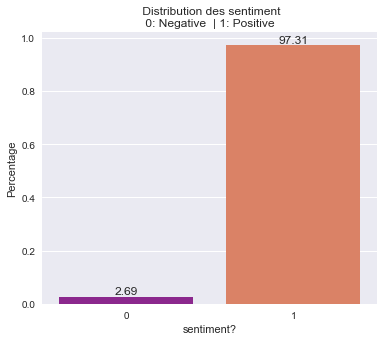

In [666]:
import seaborn as sns
plt.figure(figsize=(6, 5))
yaxis = host_reviews["sentiment"].value_counts().values / host_reviews.shape[0]
barplot = sns.barplot(x=[1,0], y=yaxis, palette = 'plasma')
for p in barplot.patches:
    barplot.annotate(format(p.get_height()*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.title(" Distribution des sentiment\n 0: Negative  | 1: Positive ")
plt.xlabel('sentiment?')
plt.ylabel('Percentage')

- Alors on remarque que notre jeu de données est non équilibrée avec 97.31% des commantaires positifs et un pourcentage de 2.69% des commentaires négatifs.

- **La solution** : est de créer un ensemble de données avec des distributions des classes équilibrées 

### Création d’un ensemble de données de sous-échantillon avec des distributions équilibrées des classes

Pour créer notre ensemble d'entraînement équilibré, on va prendre tous les commentaires négatifs dans notre ensemble de données et les comptées, ensuite, on va sélectionner au hasard le même nombre de commantaires positifs et finalement  on va faire une concaténation suivi par un mélange des données.

In [667]:
Nmbr_host_reviews_Neg = host_reviews["sentiment"].value_counts()[0]
print('on a {} commantaires négatives'.format(Nmbr_host_reviews_Neg))

on a 102 commantaires négatives


In [668]:
#randomly selecting 102  random negative review
host_reviews_Neg = host_reviews[host_reviews['sentiment'] == 0]
host_reviews_Pos = host_reviews[host_reviews['sentiment'] == 1]

In [669]:
selected = host_reviews_Pos.sample(Nmbr_host_reviews_Neg)
len(selected)

102

In [670]:

selected.reset_index(drop=True, inplace=True)
host_reviews_Neg.reset_index(drop=True, inplace=True)

In [671]:
subsample = pd.concat([selected, host_reviews_Neg])
len(subsample)

204

In [672]:
#shuffling our data set
host_reviews = subsample.sample(frac=1).reset_index(drop=True)
host_reviews.head(10)

,host_id,comments,review_scores_rating,sentiment
0,54373205,Waltrauds Wohnung ist sehr modern und schick u...,4.71,1
1,91091072,The host canceled this reservation 3 days befo...,0.00,0
2,196458339,The host canceled this reservation 3 days befo...,0.00,0
3,1153551,We had a wonderful stay in Margherita's apartm...,4.85,1
4,6704542,My friend's and I had a great time here. It is...,5.00,1
5,231419216,We reserved the place for a week. There was no...,2.00,0
6,90279278,Correu tubo bem. O apartamento correspondeu às...,4.45,1
7,214809575,"Jonathan's place was clean, the location conve...",4.13,1
8,372783365,Das Haus liegt in einer guten Gegend in Münche...,3.00,0
9,7709497,The place cosy but slightly small for more tha...,4.50,1


Text(0, 0.5, 'Percentage')

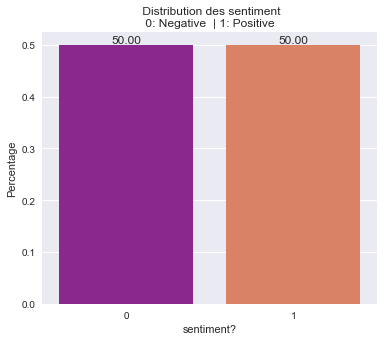

In [673]:
import seaborn as sns
plt.figure(figsize=(6, 5))
yaxis = host_reviews["sentiment"].value_counts().values / host_reviews.shape[0]
barplot = sns.barplot(x=[1,0], y=yaxis, palette = 'plasma')
for p in barplot.patches:
    barplot.annotate(format(p.get_height()*100, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.title(" Distribution des sentiment\n 0: Negative  | 1: Positive ")
plt.xlabel('sentiment?')
plt.ylabel('Percentage')

 #### 2-Nettoyage des données 

Le nettoyage de text comprendra plusieurs traitements à savoir :

- supprimer des valeurs manquantes
- supprimer la ponctuation 
- supprimer les chiffres 
- supprime les stopwords

In [674]:
host_reviews.isna().sum()

host_id                 0
comments                0
review_scores_rating    0
sentiment               0
dtype: int64

In [675]:
import re
# supprimer les balises HTML
#cleanr = re.compile('<.*?>')
#host_reviews['comments']= [re.sub(cleanr, '', s) for s in host_reviews['comments']]

host_reviews['comments']= host_reviews['comments'].str.replace('<br/>', ' ')
host_reviews['comments']= host_reviews['comments'].str.replace('\d+', ' ')
host_reviews['comments'] = host_reviews['comments'].str.replace('\n', ' ')
host_reviews['comments'] = host_reviews['comments'].str.replace('/', ' ')
#supprimer punctuation
host_reviews['comments']= [re.sub(r'[^\w\s]','',s) for s in host_reviews['comments']] 

host_reviews['comments']

0      Waltrauds Wohnung ist sehr modern und schick u...
1      The host canceled this reservation   days befo...
2      The host canceled this reservation   days befo...
3      We had a wonderful stay in Margheritas apartme...
4      My friends and I had a great time here It is v...
                             ...                        
199          MUNICHSehr freundlicher Gastgeber gute Lage
200    We only had difficulty in getting keys from ho...
201    Bemühter Gastgeber  super Lage Perfekt für ein...
202    Great place to stay in MunichVery new and clea...
203    The host canceled this reservation   days befo...
Name: comments, Length: 204, dtype: object

In [676]:
host_reviews['comments'][1]

'The host canceled this reservation   days before arrival This is an automated posting'

Puis on supprime les stopwords ou les mots vides en anglais qui sont des mots qui contiennent très peu d'informations utiles. Nous devons alors  les supprimer. 

In [677]:
import nltk
from nltk.corpus import stopwords

- nltk a une liste de mots vides pour chaque langue:

In [678]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [679]:
import nltk
stopwords = list(set(nltk.corpus.stopwords.words('english')))
host_reviews["comments"] = host_reviews["comments"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [680]:
# importation des libraries
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

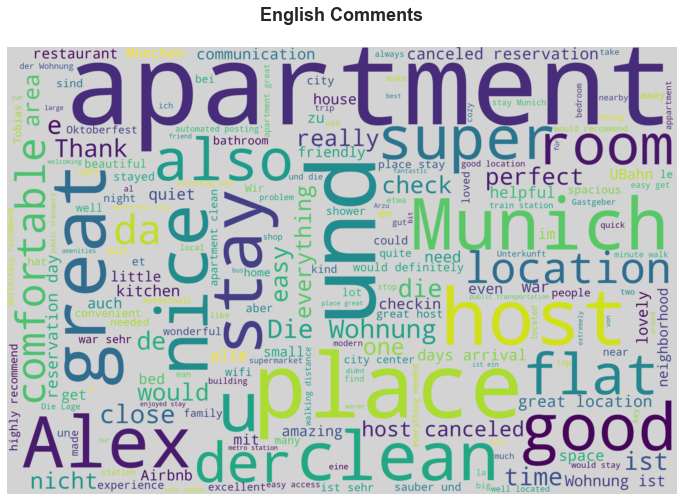

In [681]:
import re
import string
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(host_reviews.comments.values))

plot_wordcloud(wordcloud, 'English')

### 2.2. Language Detection

In [682]:
# we use Python's langdetect 
from langdetect import detect
# write the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [683]:
host_reviews['language'] = host_reviews['comments'].apply(language_detection)

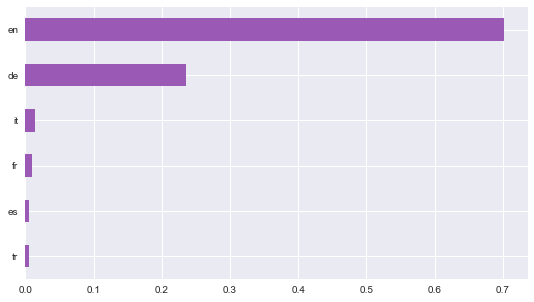

In [684]:
# visualizing the comments' languages a) quick and dirty
ax = host_reviews.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));

In [685]:
host_reviews= host_reviews.drop(['language'], axis=1)

- on supprime les stopwords des langague utlisé:

In [686]:
# on supprime stopwords de german
stopwords = list(set(nltk.corpus.stopwords.words('german')))
host_reviews["comments"] = host_reviews["comments"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [687]:
# on supprime stopwords de français
stopwords = list(set(nltk.corpus.stopwords.words('french')))
host_reviews["comments"] = host_reviews["comments"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [688]:
# on supprime stopwords de Spanish
stopwords = list(set(nltk.corpus.stopwords.words('spanish')))
host_reviews["comments"] = host_reviews["comments"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

- **Top word dans commentaires positive**

In [689]:
# full dataframe with positive  comments
df_pos = host_reviews.loc[host_reviews.sentiment ==1 ]

In [690]:
# only corpus of positive comments
pos_comments = df_pos['comments'].tolist()

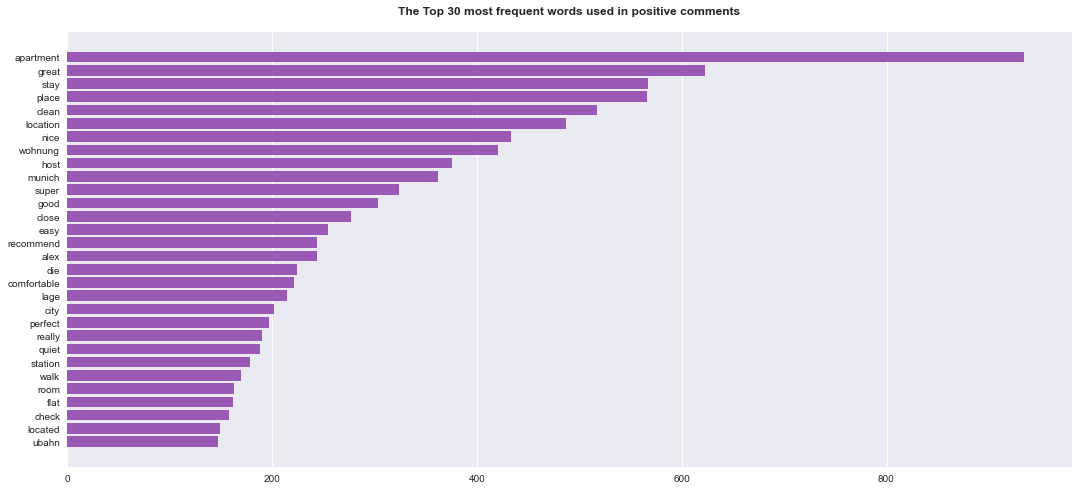

In [691]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.style import set_palette
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(pos_comments)
features = vectorizer.get_feature_names()
# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# preparing the plot
sns.set_palette(flatui)
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in positive comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

In [692]:
# import necessary libraries
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' top word positive \n', fontsize=18, fontweight='bold')
    plt.show()

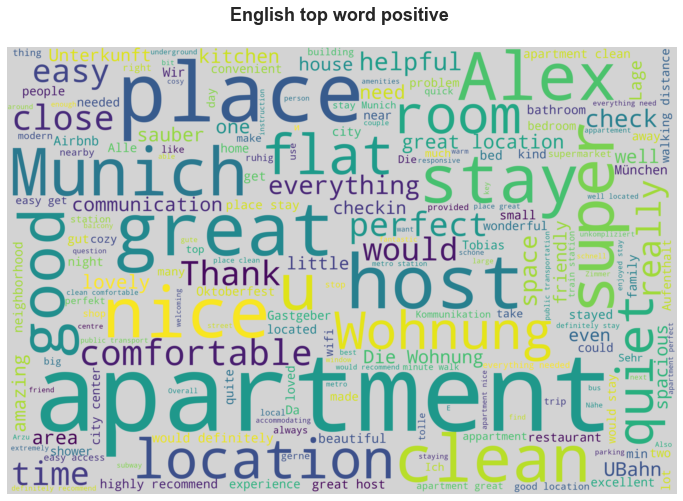

In [693]:
import re
import string
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(pos_comments))

plot_wordcloud(wordcloud, 'English')

- **Top word dans commentaires négative**

In [694]:
# full dataframe with negative  comments
df_neg = host_reviews.loc[host_reviews.sentiment ==0 ]

In [695]:
# only corpus of negative comments
neg_comments = df_neg['comments'].tolist()

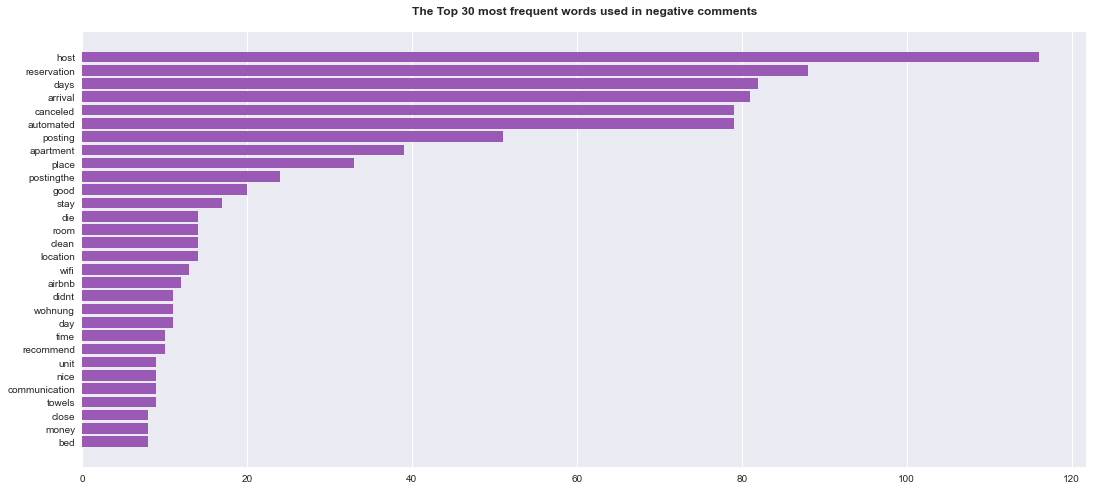

In [696]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.style import set_palette
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(neg_comments)
features = vectorizer.get_feature_names()
# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# preparing the plot
sns.set_palette(flatui)
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in negative comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

In [697]:
# import necessary libraries
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' top word negative \n', fontsize=18, fontweight='bold')
    plt.show()

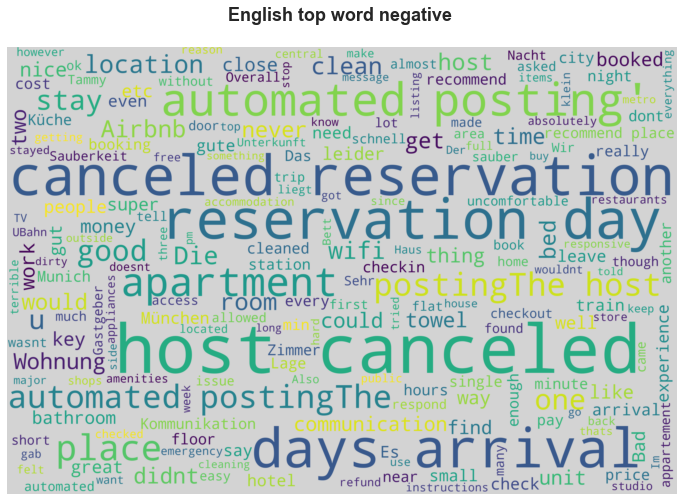

In [698]:
import re
import string
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(neg_comments))

plot_wordcloud(wordcloud, 'English')

## Tokenization

On fait le **Tokenization** qui est le processus de décomposition d'un  texte donné dans NLP en petite unité d'une phrase appelée jeton

In [699]:
from nltk.tokenize import word_tokenize
tokenizedWords = []
documents = []
# chaque document contient tuple==> la liste de mot et categorie
for i in host_reviews.index:
    sentiment =host_reviews["sentiment"][i]
    review = host_reviews["comments"][i]
    tokenizedWord = word_tokenize(review)
    document = [tokenizedWord, sentiment]
    documents.append(document)

chaque element de documents contient une liste=[contient tous les mots de document, son categorie ]


In [700]:
len(documents)

204

In [701]:
#host_reviews["comments"][4]

In [702]:
#documents[4]

### liste all word

In [703]:
listeall=[]
for i in host_reviews["comments"]:
    review = i
    tokenizedWord = word_tokenize(review)
    for j in tokenizedWord:
        listeall.append(j)
print(len(listeall))

54725


- listeall est une liste qui contient tous les mots de tous les documents , qu'on va utiliser par la suite dans la partie de bag of word 

### Bag of word

In [704]:
# Define the feature extractor
# permet de calculer la frequence de chaque mot dans le documen
all_words = nltk.FreqDist(w.lower() for w in listeall)
word_features = list(all_words)[:2000]
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features


In [705]:
#all_words.items()

In [706]:
df_fdist = pd.DataFrame.from_dict(all_words, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
print(df_fdist)

            Frequency
Term                 
waltrauds           1
wohnung           432
modern             54
schick              2
zudem               2
...               ...
cecile              1
ida                 1
munichsehr          1
aspects             1
bemühter            1

[10542 rows x 1 columns]


In [707]:

featuresets = [(document_features(d), c) for (d,c) in documents]
train_set, test_set = featuresets[100:], featuresets[:100]

In [708]:
# Train Naive Bayes classifier
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [709]:
# Test the classifier
print(nltk.classify.accuracy(classifier, test_set))

0.8


In [710]:
classifier.classify(test_set[0][0])

1

## Matrice de confusion 

In [711]:
test_result = []
gold_result = []

for i in range(len(test_set)):
    test_result.append(classifier.classify(test_set[i][0]))
    gold_result.append(test_set[i][1])

In [712]:
CM = nltk.ConfusionMatrix(gold_result, test_result)
print(CM)

  |  0  1 |
--+-------+
0 |<50> 2 |
1 | 18<30>|
--+-------+
(row = reference; col = test)



Alors notre modèle a bien classé 45 commentaires de test de classe 0 négative et 27 commentaires de classe 1 positive avec un erreur en 24 commentaires prédites dans la classe 1 mais en réalité sont de classe 0.

In [713]:
# voir quelles fonctionnalités  les plus informatives que classificateur naive Bayes a trouvé 
classifier.show_most_informative_features(5)

Most Informative Features
       contains(posting) = True                0 : 1      =     17.6 : 1.0
         contains(great) = True                1 : 0      =     17.0 : 1.0
          contains(walk) = True                1 : 0      =     15.1 : 1.0
         contains(would) = True                1 : 0      =     14.5 : 1.0
          contains(area) = True                1 : 0      =     13.9 : 1.0


la fonction show_most_informative_features() permet d'afficher les caractéristique  plus informatives que classificateur naive Bayes a trouvé pour chaque classe par exemple: ce resultat: **contains(nice) = True  1 : 0   =  21.8 : 1.0**  signifier que le mot nice positive(1) 21.8 fois qu'il est negative(0). 

**max(Pr(feature |classLabel))/min(Pr(feature | classLabel))**

## CountVectorizer 

On peut également utiliser la classe CountVectorizer de sklearn.feature_extraction.text. qui permet de Convertir une collection de documents texte en une matrice de nombres de jetons (mot).

On va définir un nombre maximum de fonctionnalités (nombre max de fonctionnalités qui aident le plus via l'attribut "max_features"). puis on va faire l'apprentissage sur le corpus ensuiteon va  appliquer la même transformation au corpus ".fit_transform(corpus)" et finalement on va le convertir en un tableau.

In [714]:
# Modèle naive_bayes
import nltk
import random
from sklearn.naive_bayes import  MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score
from sklearn.metrics import recall_score

vectorizer = CountVectorizer(max_features=3000)
X = host_reviews["comments"]
y = host_reviews["sentiment"]

# Séparation des données en 2 parties : entraînement / test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25,random_state=42)
 
train_X = vectorizer.fit_transform(train_X) 
test_X = vectorizer.transform(test_X)
# Entraînement du modèle
mnb = MultinomialNB()
mnb.fit(train_X, train_y)

# Test the classifier
predictions = mnb.predict(test_X)
score_NVB=accuracy_score(test_y, predictions) * 100
precision_NVB= precision_score(test_y, predictions) * 100
recall_NVB= recall_score(test_y, predictions) * 100
print('Score (=accuracy) du modèle  sur le jeu de test : ', round(accuracy_score(test_y, predictions) * 100, 2), '%')


Score (=accuracy) du modèle  sur le jeu de test :  86.27 %


In [715]:
from sklearn.metrics import classification_report
report = classification_report(test_y, predictions)
print(report) 

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.82      1.00      0.90        31

    accuracy                           0.86        51
   macro avg       0.91      0.82      0.84        51
weighted avg       0.89      0.86      0.86        51



### Model naive bayes avec n-grame

In [716]:
for N in range(1,5):
    vectorizer_G = CountVectorizer(max_features=3000, ngram_range=(1,N))

    X = host_reviews["comments"]
    y = host_reviews["sentiment"]

    # Séparation des données en 2 parties : entraînement / test
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25,random_state=42)
 
    train_X = vectorizer_G.fit_transform(train_X) 
    test_X = vectorizer_G.transform(test_X)
    # Entraînement du modèle
    mnb = MultinomialNB()
    mnb.fit(train_X, train_y)
    # Test the classifier
    predictions_2G = mnb.predict(test_X)
    print('Score (=accuracy) du modèle avec {} gramme: '.format(N), round(accuracy_score(test_y, predictions_2G) * 100, 2), '%')

Score (=accuracy) du modèle avec 1 gramme:  86.27 %
Score (=accuracy) du modèle avec 2 gramme:  82.35 %
Score (=accuracy) du modèle avec 3 gramme:  82.35 %
Score (=accuracy) du modèle avec 4 gramme:  80.39 %


In [717]:
from sklearn.naive_bayes import  MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score
from sklearn.metrics import recall_score


vectorizer_3G = CountVectorizer(max_features=3000, ngram_range=(1,3))

X = host_reviews["comments"]
y = host_reviews["sentiment"]

# Séparation des données en 2 parties : entraînement / test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25,random_state=42)
 
train_X = vectorizer_3G.fit_transform(train_X) 
test_X = vectorizer_3G.transform(test_X)
# Entraînement du modèle
mnb_3G = MultinomialNB()
mnb_3G.fit(train_X, train_y)

# Test the classifier
predictions_3G = mnb_3G.predict(test_X)
score_NVB_3G=accuracy_score(test_y, predictions_3G) * 100
precision_NVB_3G= precision_score(test_y, predictions_3G) * 100
recall_NVB_3G= recall_score(test_y, predictions_3G) * 100
print('Score (=accuracy) du modèle  sur le jeu de test : ', round(accuracy_score(test_y, predictions_3G) * 100, 2), '%')


Score (=accuracy) du modèle  sur le jeu de test :  82.35 %


In [718]:
# Modèle decision tree
from sklearn.tree import DecisionTreeClassifier

# Vectorisation des critiques
vectorizer = CountVectorizer(max_features=3000)
X = host_reviews["comments"]
y = host_reviews["sentiment"]

# Séparation des données en 2 parties : entraînement / test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25,random_state=42)
 
train_X = vectorizer.fit_transform(train_X) 
test_X = vectorizer.transform(test_X)

# Entraînement du modèle
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree = decision_tree.fit(train_X, train_y)
predictions_tree = decision_tree.predict(test_X)
score_DT=accuracy_score(test_y, predictions_tree) * 100
precision_DT= precision_score(test_y, predictions_tree) * 100
recall_DT= recall_score(test_y, predictions_tree) * 100
print('Score (=accuracy) du modèle decision_tree avec CountVectorizer sur le jeu de test : ', round(accuracy_score(test_y, predictions_tree) * 100, 2), '%')

Score (=accuracy) du modèle decision_tree avec CountVectorizer sur le jeu de test :  70.59 %


In [719]:
from sklearn.metrics import classification_report
report = classification_report(test_y, predictions)
print(report) 

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.82      1.00      0.90        31

    accuracy                           0.86        51
   macro avg       0.91      0.82      0.84        51
weighted avg       0.89      0.86      0.86        51



In [720]:
from sklearn.ensemble  import RandomForestClassifier

# Vectorisation des critiques
vectorizer = CountVectorizer(max_features=3000)
X = host_reviews["comments"]
y = host_reviews["sentiment"]

# Séparation des données en 2 parties : entraînement / test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25,random_state=42)
 
train_X = vectorizer.fit_transform(train_X) 
test_X = vectorizer.transform(test_X)

# Entraînement du modèle
rf = RandomForestClassifier(max_depth=None, random_state=32,n_estimators=500)
rf = rf.fit(train_X, train_y)
predictions = rf.predict(test_X)
score_RF=accuracy_score(test_y, predictions) * 100
precision_RF= precision_score(test_y, predictions) * 100
recall_RF= recall_score(test_y, predictions) * 100
print('Score (=accuracy) du modèle decision_tree avec CountVectorizer sur le jeu de test : ', round(accuracy_score(test_y, predictions) * 100, 2), '%')

Score (=accuracy) du modèle decision_tree avec CountVectorizer sur le jeu de test :  76.47 %


In [721]:
from sklearn.metrics import classification_report
report = classification_report(test_y, predictions)
print(report)  

              precision    recall  f1-score   support

           0       0.68      0.75      0.71        20
           1       0.83      0.77      0.80        31

    accuracy                           0.76        51
   macro avg       0.75      0.76      0.76        51
weighted avg       0.77      0.76      0.77        51



#### Comparaison des résultat:

In [722]:
import pandas as pd
import numpy as np
pd= pd.DataFrame(np.array([[score_NVB,precision_NVB,recall_NVB],[score_DT,precision_DT,recall_DT],[score_RF,precision_RF,recall_RF]]),
                columns=['accuracy', 'precision','recall_score'], index=['Naive Bayes', 'Decision Tree ','Random Forest'])
pd 

,accuracy,precision,recall_score
Naive Bayes,86.274510,81.578947,100.000000
Decision Tree,70.588235,78.571429,70.967742
Random Forest,76.470588,82.758621,77.419355


### Model naive bayes avec TfidfVectorizer

In [723]:
# Modèle3 naive_bayes
import nltk
import random
from sklearn.naive_bayes import  MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score
from sklearn.metrics import recall_score

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_TFIDF = TfidfVectorizer(max_features=3000)

X = host_reviews["comments"]
y = host_reviews["sentiment"]

# Séparation des données en 2 parties : entraînement / test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25,random_state=42)
 
train_X = vectorizer_TFIDF.fit_transform(train_X) 
test_X = vectorizer_TFIDF.transform(test_X)

# Entraînement du modèle
mnb_tf = MultinomialNB()
mnb_tf.fit(train_X, train_y)

# Test the classifier
predictions_TF = mnb_tf.predict(test_X)
score_NVB_TF=accuracy_score(test_y, predictions_TF) * 100
precision_NVB_TF= precision_score(test_y, predictions_TF) * 100
recall_NVB_TF= recall_score(test_y, predictions_TF) * 100
print('Score (=accuracy) du modèle  sur le jeu de test : ', round(accuracy_score(test_y, predictions_TF) * 100, 2), '%')


Score (=accuracy) du modèle  sur le jeu de test :  82.35 %


In [724]:
# Modèle3 naive_bayes
import nltk
import random
from sklearn.naive_bayes import  MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score
from sklearn.metrics import recall_score

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_TFIDF = TfidfVectorizer(max_features=3000, ngram_range=(1,3))

X = host_reviews["comments"]
y = host_reviews["sentiment"]

# Séparation des données en 2 parties : entraînement / test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25,random_state=42)
 
train_X = vectorizer_TFIDF.fit_transform(train_X) 
test_X = vectorizer_TFIDF.transform(test_X)

# Entraînement du modèle
mnbtfG = MultinomialNB()
mnbtfG.fit(train_X, train_y)

# Test the classifier
predictions_TF_G = mnbtfG.predict(test_X)
score_NVB_TF_G=accuracy_score(test_y, predictions_TF_G) * 100
precision_NVB_TF_G= precision_score(test_y, predictions_TF_G) * 100
recall_NVB_TF_G= recall_score(test_y, predictions_TF_G) * 100
print('Score (=accuracy) du modèle  sur le jeu de test : ', round(accuracy_score(test_y, predictions_TF_G) * 100, 2), '%')


Score (=accuracy) du modèle  sur le jeu de test :  76.47 %


In [725]:
import pandas as pd
import numpy as np
pd= pd.DataFrame(np.array([[score_NVB,precision_NVB,recall_NVB],[score_NVB_3G,precision_NVB_3G,recall_NVB_3G],[score_NVB_TF,precision_NVB_TF,recall_NVB_TF],[score_NVB_TF_G,precision_NVB_TF_G,recall_NVB_TF_G]]),
                columns=['accuracy', 'precision','recall_score'], index=['Naive Bayes avec CountVectorizer 1_gram', 'Naive Bayes avec CountVectorizer 3_gram ','Naive Bayes avec TfidfVectorizer 1_gram','Naive Bayes avec TfidfVectorizer 3_gram'])
pd 

,accuracy,precision,recall_score
Naive Bayes avec CountVectorizer 1_gram,86.274510,81.578947,100.000000
Naive Bayes avec CountVectorizer 3_gram,82.352941,77.500000,100.000000
Naive Bayes avec TfidfVectorizer 1_gram,82.352941,78.947368,96.774194
Naive Bayes avec TfidfVectorizer 3_gram,76.470588,74.358974,93.548387
